In [16]:
import sys
sys.path.insert(0, '../python/casadi_f16')
import f16
import control
import numpy as np
import matplotlib.pyplot as plt
from analysis import loop_analysis

plt.rcParams['figure.figsize'] = (10, 10)

In [17]:
!pip install casadi

# Roll Autopilot Design

* See Roll Autopilot design example in section 4.6 of Stevens and Lewis.

* Homework 1: Due 9/4 @  11 pm: Trim the F16 model around a VT=550 ft/s, 20 deg/s yaw rate turn.
* Find the A, B, C, D matrices for the state space model.
* Find the transfer function for the elevator to pitch rate (Q).
* Design a PID controller meeting the following specifications
     * Maximum overshoot: 20% in pitch rate
     * Rise time: 0.1 second
     * Settling time 1 second
* Simulate and plot the response of your controlled linear system model for a step response in roll rate of 10 deg/s and 100 deg/s.
* Using git, fork aae497-f16 on github. Complete the homework. Submit your homework via pull request on aae497-f16

In [18]:
p = f16.Parameters()
x0, u0 = f16.trim(x=f16.State(VT=550), p=p, phi_dot=0.0, theta_dot=0, psi_dot=0.35, gam=0)

In [19]:
def select(n, i):
    D = np.zeros((1, n))
    D[0, i] = 1
    return control.ss([], [], [], D)

In [44]:
ss = f16.linearize(x0, u0, p)
s = control.tf([1, 0], [0, 1])
G = -(180/np.pi)*ss.sub_system(x=['alpha', 'Q', 'elv_deg'],
                  u=['elv_cmd_deg'], y=['alpha', 'Q']).to_control()
kalpha = 0.2
sys3 = control.feedback(G, kalpha*10/(s+10)*select(2, 0))
sys3

A = [[-1.15172381e+00  9.03410483e-01 -2.33982494e-03  0.00000000e+00]
 [ 3.98011044e+00 -1.48162479e+00 -2.35792732e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.02020000e+01  2.31497868e+03]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e+01]]

B = [[    0.        ]
 [    0.        ]
 [-1157.48933772]
 [    0.        ]]

C = [[1. 0. 0. 0.]
 [0. 1. 0. 0.]]

D = [[0.]
 [0.]]

3 states have been removed from the model


[-21, 0, -8, 8]

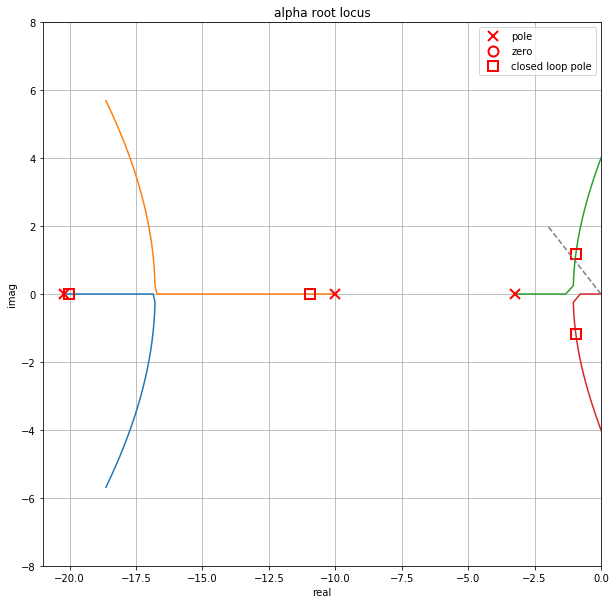

In [21]:
from analysis import rlocus
H = (10/(s+10))*select(2, 0)
plt.figure()
kalpha = 0.35
rlocus('alpha', control.minreal(H*G), kvect=np.linspace(0, 10, 1000), k=kalpha);
plt.plot([0, -2], [0, 2], '--')
plt.axis([-21, 0, -8, 8])

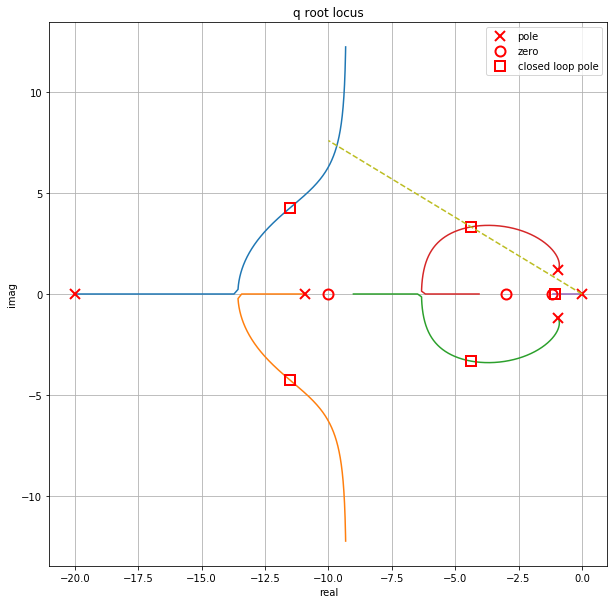

In [36]:
plt.figure()
sys3 = control.feedback(G, kalpha*(10/(s+10))*select(2, 0))
rlocus('q', (s+3)/s*sys3[1, 0], kvect=np.linspace(0, 1, 1000), k=0.5)
zeta_des = 0.707 # baed on max overshoot
plt.plot([0, -10], [0, 10*np.cos(zeta_des)], '--')
#plt.axis([-20, 0, -5, 5])

In [26]:
G0 = (s+3)/s*sys3[1, 0]
Gc = control.feedback(G0,1)


         272.9 s^3 + 3873 s^2 + 1.241e+04 s + 9753
-----------------------------------------------------------
s^5 + 32.84 s^4 + 552.6 s^3 + 4358 s^2 + 1.291e+04 s + 9753

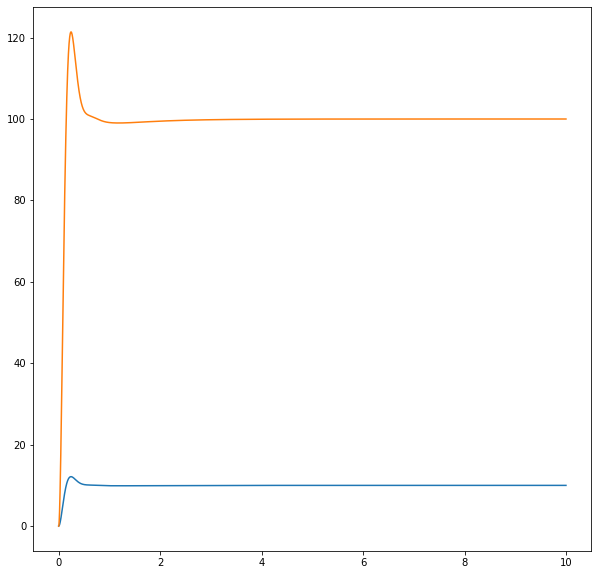

In [41]:
t,y = control.step_response(Gc, T=np.linspace(0,10,10000))
plt.plot(t,10*y)
plt.plot(t,100*y)

In [38]:
def f_control(t, x):
    return f16.Control(
        thtl=u0.thtl,
        ail_cmd_deg=u0.ail_cmd_deg,
        elv_cmd_deg=u0.elv_cmd_deg + 1*np.sin(2*np.pi*2*t),
        rdr_cmd_deg=u0.rdr_cmd_deg)

f_control(0, x0)

Control(thtl=DM(0.941823), ail_cmd_deg=DM(0.0834429), elv_cmd_deg=DM(-1.40861), rdr_cmd_deg=DM(-0.351551))

Text(0.5, 1.0, 'angle of attack')

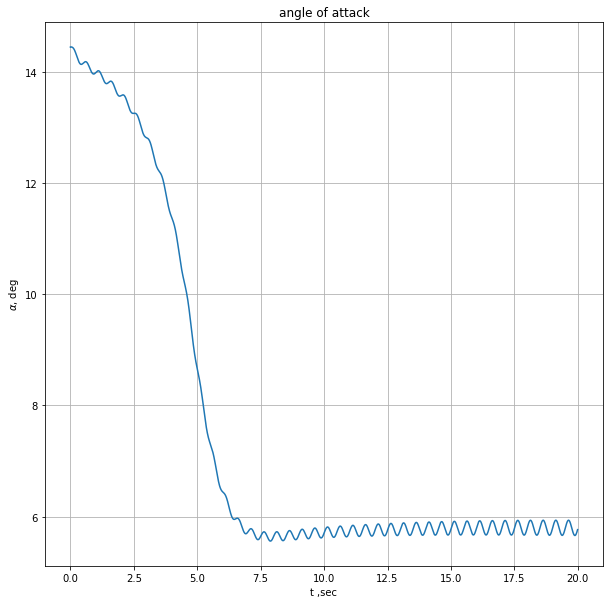

In [39]:
res = f16.simulate(x0, f_control, p, 0, 20, 0.01)
plt.plot(res['t'], np.rad2deg(res['x'][:, f16.State().name_to_index('alpha')]))
plt.xlabel('t ,sec')
plt.ylabel(r'$\alpha$, deg')
plt.grid()
plt.title('angle of attack')

Text(0.5, 1.0, 'trajectory')

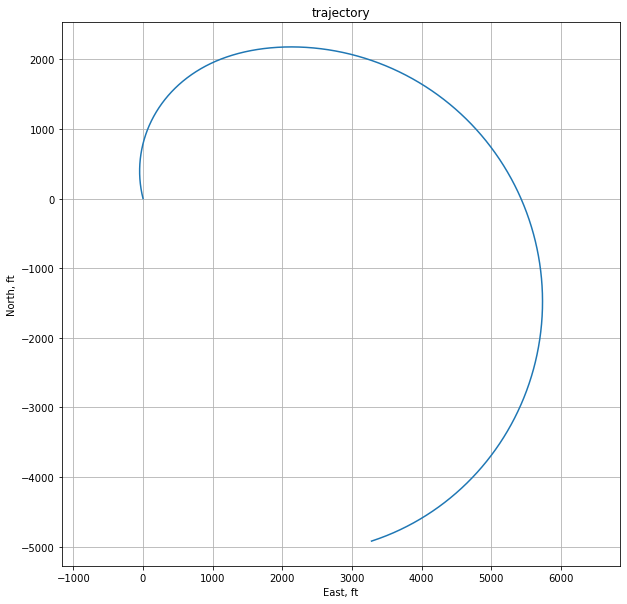

In [40]:
res = f16.simulate(x0, f_control, p, 0, 20, 0.01)

plt.plot(res['x'][:, f16.State().name_to_index('p_E')], res['x'][:, f16.State().name_to_index('p_N')])
plt.axis('equal');
plt.xlabel('East, ft')
plt.ylabel('North, ft')
plt.grid()
plt.title('trajectory')